# Análisis de Clasificación — Cáncer de Mama (Regresión Logística)

## Introducción
Este notebook presenta un análisis de datos y un modelo de regresión logística aplicado al conjunto de datos *Breast Cancer Wisconsin (Diagnostic)*. El objetivo principal es detectar tumores malignos y benignos a partir de características morfológicas extraídas de imágenes de aspirado por aguja fina (FNA). Este documento está redactado con un enfoque de portafolio profesional: explicar qué se hizo, por qué, y cuáles fueron los resultados de forma clara para reclutadores y equipos técnicos.

## Descripción del dataset
- Origen: UCI Machine Learning Repository (Breast Cancer Wisconsin - Diagnostic).
- Observaciones: cada fila corresponde a una imagen FNA de un tumor.
- Etiqueta objetivo: `diagnosis` (M = maligno, B = benigno, convetido en maligno = 1, benigno =0).
- Atributos: 30 características numéricas (media, error estándar y peor de 10 medidas morfológicas como radio, textura, perímetro, área, suavidad, compacidad, concavidad, puntos cóncavos, simetría y dimensión fractal).

## Objetivo del proyecto
1. Realizar un Análisis Exploratorio de Datos (EDA) para entender la distribución y relación entre variables morfológicas.
2. Construir y evaluar un modelo de regresión logística para clasificar tumores.
3. Enfocarse en **minimizar los falsos negativos** (casos donde el modelo clasifica como benigno a un caso maligno), priorizando la seguridad clínica.

## Metodología 
1. Carga y limpieza de datos.
2. Análisis exploratorio (estadísticas descriptivas, visualizaciones y correlaciones).
3. Separación en conjuntos de entrenamiento y prueba.
4. Entrenamiento de un modelo de regresión logística.
5. Evaluación con métricas clave: matriz de confusión, precisión, recall (sensibilidad), especificidad y AUC-ROC. Se presta especial atención al *recall* del grupo maligno.
6. Se ajusta el umbral de clasificación para mayor sensibilidad.

## Resultados principales 
- Se entrenó una regresión logística y se evaluó en conjunto de prueba.
- Se observó un trade-off entre precisión y sensibilidad; tomando decisiones para reducir falsos negativos se puede sacrificar algo de especificidad.
- Métricas detalladas y curvas (ROC) se encuentran en la sección de resultados del notebook.
---

## Índice de contenido

1. [Carga de datos](#1-carga-de-datos)
2. [Limpieza de datos](#2-limpieza-de-datos)
3. [Análisis Exploratorio de Datos (EDA)](#section-3)
4. [Modelo ML](#4-modelo-ml)
5. [Análisis de umbrales](#section-5)
6. [Modelo con umbral personalizado](#6-modelo-con-umbral-personalizado)
7. [Conclusiones del Análisis](#section-7)

# 1. Carga de datos.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')
from scipy import stats

In [2]:

path = r'C:\Users\Ernes\OneDrive\Documents\Modelos ML\Data\BreastCancer.csv'
df = pd.read_csv(path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# 2. Limpieza de datos.

## NaN Values

In [3]:
#eliminamos la columna innecesaria
df.drop(columns=['id','Unnamed: 32'],inplace=True)
#col id no sirve para el analisis.
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

## Valores duplicados

In [4]:
df.duplicated().any()

False

## Transformación variable objetivo.

In [5]:
#Cambiamos la estructura de la variable objetivo donde 'M':1 y 'B':0.
#Nos interesa predecir si una mujer tiene cancer de mama, por ello 'M':1
df['diagnosis'].replace({'M':1,'B':0},inplace=True)

## Optimización de la información.

Se recomienda optimizar a partir de las 100,000 filas, esto lo haremos con fines didácticos.

In [6]:
#Uso de memoria inicial
df.memory_usage(deep=True)


Index                       132
diagnosis                  4552
radius_mean                4552
texture_mean               4552
perimeter_mean             4552
area_mean                  4552
smoothness_mean            4552
compactness_mean           4552
concavity_mean             4552
concave points_mean        4552
symmetry_mean              4552
fractal_dimension_mean     4552
radius_se                  4552
texture_se                 4552
perimeter_se               4552
area_se                    4552
smoothness_se              4552
compactness_se             4552
concavity_se               4552
concave points_se          4552
symmetry_se                4552
fractal_dimension_se       4552
radius_worst               4552
texture_worst              4552
perimeter_worst            4552
area_worst                 4552
smoothness_worst           4552
compactness_worst          4552
concavity_worst            4552
concave points_worst       4552
symmetry_worst             4552
fractal_

In [7]:
dtype_dict = {df.columns[0]: 'uint8'}  # Para binario 0,1
dtype_dict.update({col: 'float32' for col in df.columns[1:]}) #Para las columnas restantes, convertimos a float32
df = df.astype(dtype_dict)

In [8]:
#Uso de memoria final
df.memory_usage(deep=True)

Index                       132
diagnosis                   569
radius_mean                2276
texture_mean               2276
perimeter_mean             2276
area_mean                  2276
smoothness_mean            2276
compactness_mean           2276
concavity_mean             2276
concave points_mean        2276
symmetry_mean              2276
fractal_dimension_mean     2276
radius_se                  2276
texture_se                 2276
perimeter_se               2276
area_se                    2276
smoothness_se              2276
compactness_se             2276
concavity_se               2276
concave points_se          2276
symmetry_se                2276
fractal_dimension_se       2276
radius_worst               2276
texture_worst              2276
perimeter_worst            2276
area_worst                 2276
smoothness_worst           2276
compactness_worst          2276
concavity_worst            2276
concave points_worst       2276
symmetry_worst             2276
fractal_

<div id="section-3"></div>

# 3. Análisis Exploratorio de Datos (EDA)
En esta sección se exploran las variables morfológicas mediante estadísticas descriptivas, histogramas, diagramas de dispersión y correlaciones. El objetivo es entender la distribución de los datos y posibles relaciones entre características.


## Porcentaje entre grupos.

In [9]:
df['diagnosis'].value_counts(normalize=True) * 100 #Porcentaje por clase

0    62.741652
1    37.258348
Name: diagnosis, dtype: float64

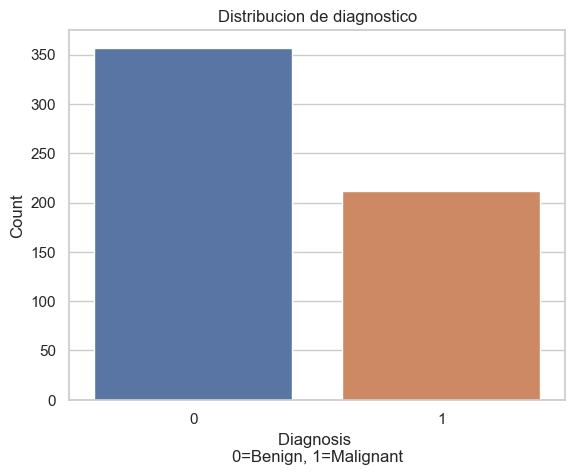

In [10]:
sns.countplot(x='diagnosis',data=df)
plt.title('Distribucion de diagnostico')
plt.xlabel('Diagnosis \n0=Benign, 1=Malignant')
plt.ylabel('Count')
plt.show()

In [11]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289650,91.969032,654.889038,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269192,25.677223,107.261215,880.583130,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524048,4.301038,24.298983,351.914093,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833241,6.146256,33.602535,569.356873,0.022832,0.157337,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790001,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.199997,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.169998,420.299988,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110001,515.299988,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.239998,551.099976,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660004,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.799999,104.099998,782.700012,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790001,29.719999,125.400002,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110001,39.279999,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040001,49.540001,251.199997,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Correlación con la variable objetivo.

In [12]:

corr_matrix = df.corr(numeric_only=True)
corr_matrix['diagnosis'].sort_values(ascending=False)


diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

Al ser variables morfológicas manejaremos todas la columnas como nuestras variables independientes.

## Gráficas de frecuencias para algunas variables morfológicas.

In [13]:
def plotFrecuencias(variable):
    hist_malignant = plt.hist(df[df["diagnosis"] == 1][variable],bins=30,fc = (1,0,0,0.5),label = 'Maligno')
    hist_benign = plt.hist(df[df["diagnosis"] == 0][variable],bins=30,fc = (0,1,0,0.5),label = 'Benigno')

    plt.legend()
    plt.xlabel(variable)
    plt.ylabel("Frecuencia")
    plt.title(f'Histograma de  {variable} en tumores')
    plt.show()

    frequent = hist_malignant[0].max()
    index_frequent = list(hist_malignant[0]).index(frequent)
    most_frequent_malignant = hist_malignant[1][index_frequent]
 
    print(f'Valor mas frecuente de {variable} es: {most_frequent_malignant}')

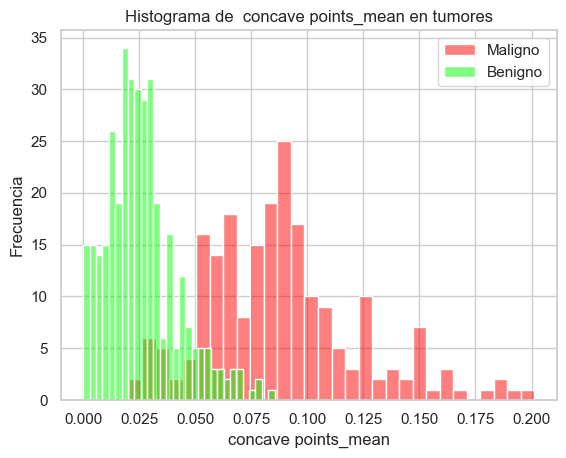

Valor mas frecuente de concave points_mean es: 0.08663632720708847


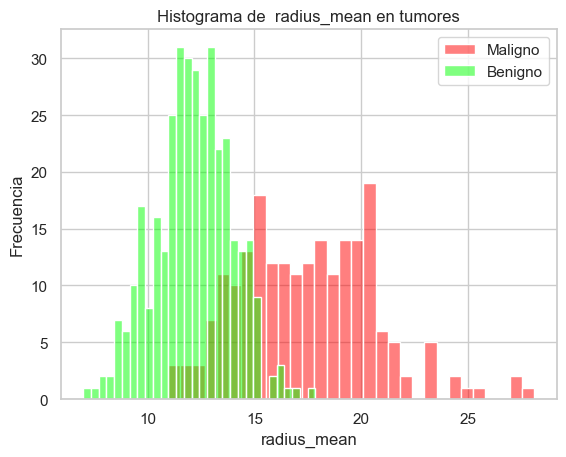

Valor mas frecuente de radius_mean es: 20.102001190185547


In [14]:
vars = ['concave points_mean','radius_mean']
for var in vars:
    plotFrecuencias(var)

Podemos notar lo siguiente:
- Las pacientes con tumores malignos tienden a tener en promedio, mayor cantidad de concavidades en los bordes del núcleo, es decir, bordes más irregulares.
- El radio del núcleo en pacientes con tumores malignos tiende a ser más grande. 

## Relación entre radio y concavidad

<Axes: xlabel='radius_mean', ylabel='concave points_mean'>

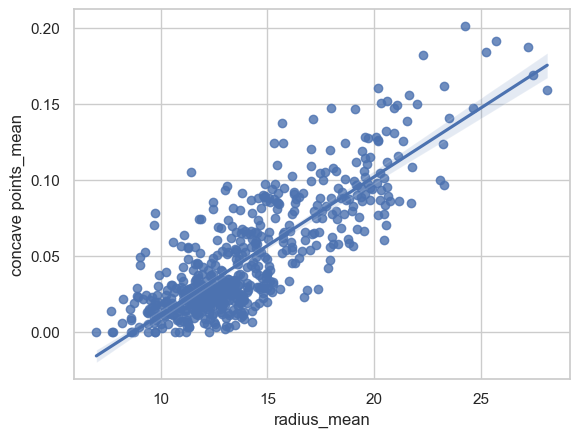

In [15]:
sns.regplot(x=df['radius_mean'],y=df['concave points_mean'],data=df)

In [16]:
df[['radius_mean', 'concave points_mean']].corr(method='pearson').iloc[1]

radius_mean            0.822529
concave points_mean    1.000000
Name: concave points_mean, dtype: float64

Existe una correlacion fuerte ( $r= 0.822529$) entre las dos variables `'radius_mean'`,`'concave points_mean'`

## Tamaño de efecto Cohen

In [17]:
df_malignant = df[df['diagnosis'] == 1].copy()
df_benign = df[df['diagnosis'] == 0].copy()

In [18]:
def cohen(var):
    mean_diff = df_malignant[var].mean() - df_benign[var].mean()
    var_bening = df_benign[var].var()
    var_malignant = df_malignant[var].var()

    s = (len(df_benign)*var_bening + len(df_malignant)*var_malignant ) / float(len(df_benign)+ len(df_malignant))
    d = mean_diff/np.sqrt(s)

    print(f'Effect size of {var}: {d}')

In [19]:
cohen('concave points_mean')
cohen('radius_mean')

Effect size of concave points_mean: 2.544337418091669
Effect size of radius_mean: 2.204858743482107


La probabilidad de que una persona con un tumor maligno tenga valores mas grandes en las variables `'radius_mean'`,`'concave points_mean'` es de aproximadamente el $95\%$

# 4. Modelo ML

## Modelado de Regresión Logística
Aquí se entrena un modelo de regresión logística usando el conjunto de entrenamiento y se evalúa con el conjunto de prueba. Se analizan métricas clave como precisión, recall y AUC-ROC.


In [20]:
#Librerias
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    recall_score,
    precision_score,
    f1_score
)

In [21]:
# Variables
X = df.drop(columns='diagnosis').copy() #Features
y = df['diagnosis'].copy() #Target

In [22]:
#Dividir entrenamiento prueba
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

model = LogisticRegression(solver='liblinear')
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [23]:
#predicciones
y_pred = model.predict(X_test)

#probabilidad de prediccion
y_pred_prob = model.predict_proba(X_test)

## Resultados y Evaluación
Se presentan los resultados del modelo, incluyendo la matriz de confusión y la curva ROC. Se discute el impacto de los falsos negativos y cómo ajustar el umbral puede influir en la sensibilidad del modelo.


In [24]:
def plot_model_evaluation(y_test, y_pred, y_pred_prob, model_name="Model"):
   """
   Genera gráficos de evaluación del modelo: Matriz de Confusión y Curva ROC
   
   Parámetros:
   - y_test: valores reales
   - y_pred: predicciones del modelo
   - y_pred_prob: probabilidades predichas
   - model_name: nombre del modelo para los títulos
   """
   
   # Crear subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
   
   # 1. Matriz de Confusión
   cm = confusion_matrix(y_test, y_pred)
   sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax1)
   ax1.set_title(f'{model_name} Matriz de confusion')
   ax1.set_xlabel('Clasificado')
   ax1.set_ylabel('Dato real')
    
   # 2. Curva ROC
   if y_pred_prob.ndim > 1:  # Si tiene múltiples columnas
       y_prob = y_pred_prob[:, 1]
   else:  # Si es un array 1D
       y_prob = y_pred_prob
   
   fpr, tpr, thresholds = roc_curve(y_test, y_prob)
   roc_auc = auc(fpr, tpr)
   
   ax2.plot(fpr, tpr, label=f'{model_name} ROC (AUC = {roc_auc:.4f})', color='green')
   ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
   ax2.set_xlabel('False Positive Rate')
   ax2.set_ylabel('True Positive Rate')
   ax2.set_title(f'ROC Curve - {model_name}')
   ax2.legend(loc="lower right")
   ax2.grid(True, alpha=0.3)
   
   plt.tight_layout()
   plt.show()
   
   # Mostrar métricas adicionales
   print(f"\n Métricas de {model_name}:")
   print(f"AUC Score: {roc_auc:.4f}")
   print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
   print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# Uso de la función:
# plot_model_evaluation(y_test, y_pred, y_pred_prob, "Logistic Regression")

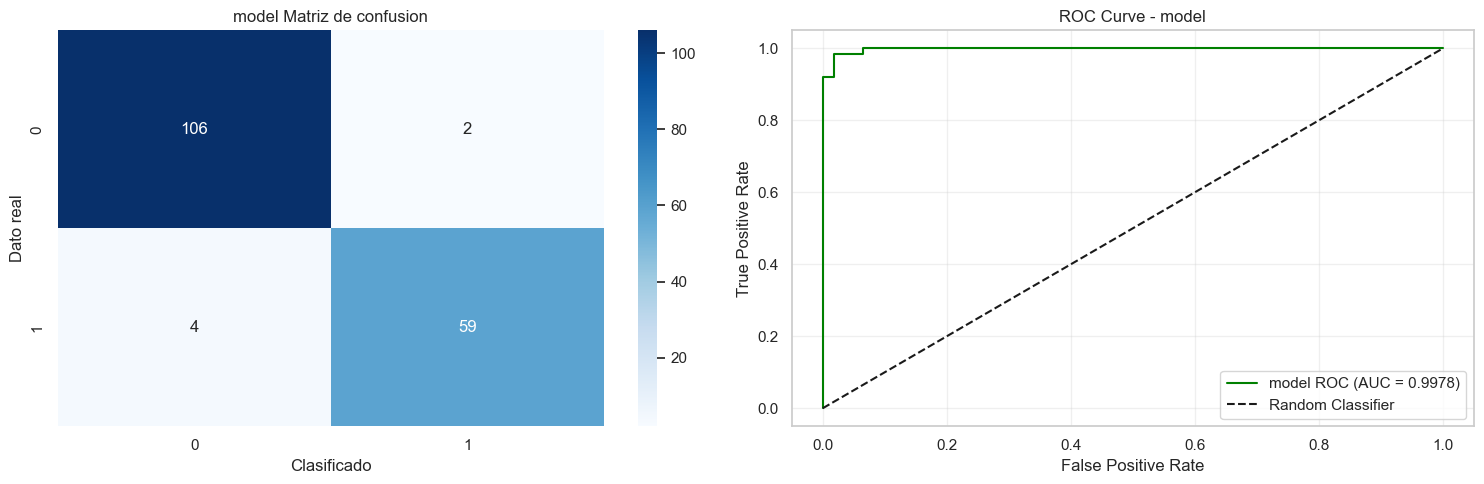


 Métricas de model:
AUC Score: 0.9978
Accuracy: 0.9649
F1-Score: 0.9516


In [25]:
plot_model_evaluation(y_test, y_pred, y_pred_prob, model_name="model")

In [26]:
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

Recall: 0.9365079365079365


Tenemos un F1-Score aceptable de 0.95, sin embargo nos interesa disminuir los falsos negativos. Para esto, analizaremos un umbral optimo.

<div id="section-5"></div>

<div id="section-5"></div>

# 5. Análisis de umbrales
Analisaremos el mejor umbral para obtener un F1 óptimo, de entre 0.7-0.9

In [27]:
def prob_labels(predict_prob, umbral = 0.5):
    predic = np.zeros([len(predict_prob), ]) #Creacion array zeros
    predic[predict_prob[:,1]>= umbral] = 1   #Umbral personalizado
    return predic

In [28]:
def evaluate_umbral(umbral):
    #Metricas
    predict_umbral = prob_labels(y_pred_prob,umbral)
    precision_umbral = precision_score(y_test, predict_umbral)
    recall_umbral = recall_score(y_test, predict_umbral)
    F1_umbral = f1_score(y_test, predict_umbral)

    return (umbral,precision_umbral,recall_umbral,F1_umbral)

In [29]:
umbrales = np.linspace(0.,1.,1000) #Definimos 1000 umbrales de 0 a 1

In [30]:
evaluation = pd.DataFrame([evaluate_umbral(x) for x in umbrales],
                            columns=['umbral','precision','recall','F1'])

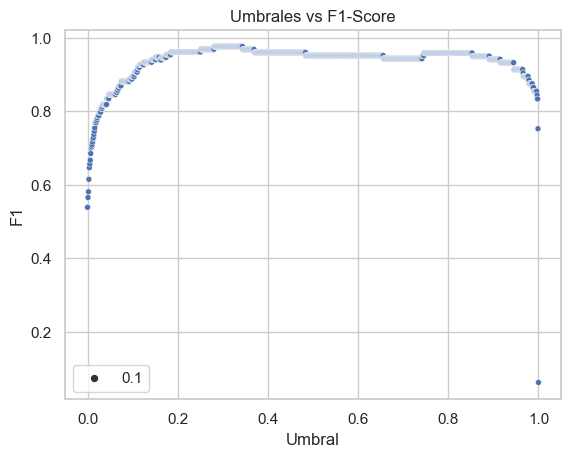

In [31]:
## Grafica de umbrales vs F1-Score
sns.scatterplot(x='umbral', y='F1', data=evaluation, marker="o",size=0.1)
plt.title('Umbrales vs F1-Score')
plt.xlabel("Umbral")
plt.ylabel("F1")
plt.show()

In [32]:
fila_max_f1 = evaluation.loc[evaluation['F1'].idxmax()]
print(fila_max_f1)

umbral       0.281281
precision    0.968750
recall       0.984127
F1           0.976378
Name: 281, dtype: float64


Para un umbral de 0.281281 se obtiene un aumento de F1 en un $2\%$.

Dado el contexto del análisis (clasificación de cáncer benigno-maligno) el aumento se considera significativo.

# 6. Modelo con umbral personalizado

In [33]:
y_pred_umbral = prob_labels(y_pred_prob,umbral=fila_max_f1[0])

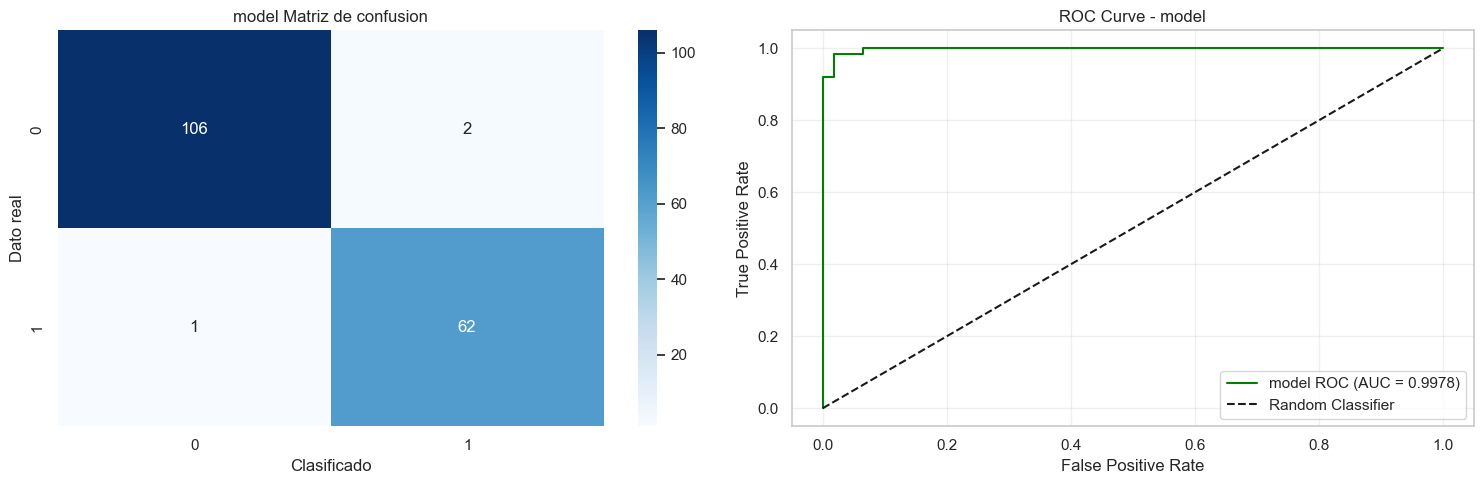


 Métricas de model:
AUC Score: 0.9978
Accuracy: 0.9825
F1-Score: 0.9764


In [34]:
plot_model_evaluation(y_test,y_pred_umbral,y_pred_prob,model_name='model')

In [35]:
recall = recall_score(y_test, y_pred_umbral)
print(f"Recall: {recall}")

Recall: 0.9841269841269841


Tenemos una disminución de falsos negativos del $75\%$

El modelo es suficientemente preciso con un $AUC= 0.9978$ 

<div id="section-7"></div>

# 7. Conclusiones del Análisis

## Características de la Base de Datos
- La base de datos contiene **37% de casos con tumores malignos** y 63% de casos benignos, mostrando un desbalance moderado hacia casos benignos.

## Variables más Correlacionadas con el Diagnóstico
Las tres variables que presentan las correlaciones más fuertes respecto a la variable objetivo son:

| Variable | Correlación |
|----------|-------------|
| `concave points_worst` | 0.793 |
| `perimeter_worst` | 0.782 |
| `concave points_mean` | 0.777 |

## 7.1 Patrones Identificados en Tumores Malignos

### Características Morfológicas
- **Concavidades en los bordes**: Los pacientes con tumores malignos tienden a presentar mayor cantidad de concavidades en los bordes del núcleo, indicando **bordes más irregulares**. 
  - Valor más frecuente de `concave points_mean`: **0.087**

- **Tamaño del núcleo**: El radio del núcleo en pacientes con tumores malignos tiende a ser **significativamente mayor**.
  - Valor más frecuente de `radius_mean`: **20.102**

### Relación entre Variables
- Existe una **correlación fuerte** (r = 0.82) entre el radio del núcleo y las concavidades de sus bordes, sugiriendo que núcleos más grandes tienden a tener bordes más irregulares.

### Efecto Cohen
- La probabilidad de que una persona con tumor maligno presente valores más altos en las variables `radius_mean` y `concave points_mean` comparado con tumores benignos es de aproximadamente **95%**.

---

## 7.2 Modelo

### Optimización de Umbrales
Mediante el ajuste de umbrales de clasificación se logró:

- **Incremento en F1-Score**: +2%
- **Incremento en Recall**: +5%

> **Nota**: Dado el contexto médico del modelo, este aumento del 2% en F1-Score es **significativo**, ya que representa una mejora importante en la capacidad de detectar correctamente casos malignos, reduciendo tanto falsos positivos como falsos negativos.